In [8]:
from conv.mixgcn import MixGCN
import yaml
with open('./config.yaml') as f:
    config = yaml.safe_load(f)
config['model']['hidden_channels'] = 128
config['model']['num_layers'] = 3
model = MixGCN(config)
model.load_state_dict(torch.load('data/mixgcn.pth'))
item_emb, user_emb = model()
item_emb = torch.mean(item_emb, dim=1)
user_emb = torch.mean(user_emb, dim=1)
score  = user_emb @ item_emb.T

In [1]:
from conv.ggnn import HeteroGGNNEmb
import yaml
with open('config.yaml') as f:
    config = yaml.safe_load(f)
config['log']=False
config['k'] = 20
config['save'] = True
config['device'] = 'cuda:0'
config['explain_num'] = 3
config['epoch_num'] = 1000
config['batch_size'] = 8192
config['model']['model_type'] = 'ggnnemb'
config['model']['num_layers'] = 4
config['model']['hidden_channels'] = 128
config['model']['concat'] = False
config['model']['ReLU'] = True
config['model']['pool'] = 'mean'
config['trainer']['explain_span'] = 5
config['trainer']['lr'] = 5e-4
config['trainer']['loss_city_weight'] = 0
config['trainer']['loss_category_weight'] = 0
config['trainer']['loss_word_weight'] = 0
config['trainer']['loss_pref_weight'] = 0
config['trainer']['city_pop_weight']=0
config['trainer']['spot_pop_weight']=0.1
config['trainer']['sampling'] = 'lgcn'
config['trainer']['drop_edge'] = False
config['trainer']['drop_attr'] = False
config['trainer']['loss_weight'] = False
config['data']['spot'] = None #数字かNone
config['data']['word'] = True
config['data']['city'] = True
config['data']['category'] = True
config['data']['pref'] = True
config['data']['station'] = False
config['data']['popularity'] = False
config['data']['multi'] = True
config['data']['init_std'] = 0
from dataloader import get_data
data = get_data(config)
model = HeteroGGNNEmb(data, config)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
mask is [8 1 3 ... 9 3 7]


In [2]:
model.load_state_dict(torch.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/ggnnemb/4_False_True.pth'))
model.to('cuda:0')
data.to('cuda:0')
model.eval()
spot_x=model(data.x_dict, data.edge_index_dict)[0]['spot']
user_x = model(data.x_dict, data.edge_index_dict)[0]['user']
score_ggnn = user_x @ spot_x.T
neg_spots = np.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/unappear_spots.npy')
neg_spots = neg_spots
user_pos = torch.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/user_pos.pt')
item_pos = torch.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/item_pos.pt')
score_ggnn[user_pos,item_pos]=-1e9
score_ggnn[:, torch.tensor(neg_spots)]=-1e9
score_ggnn = score_ggnn.cpu()

In [ ]:
recall=0
precision=0
for i,s in enumerate(score_ensemble):
    indices = torch.topk(s, 20).indices
    r = torch.isin(torch.tensor(test_item[i]), indices).sum()
    recall+=r/len(test_item[i])
    precision+=r/20
recall/=len(score)
precision/=len(score)
print(recall, precision)

tensor(0.2365) tensor(0.1275)


In [3]:
with open('/home/yamanishi/project/trip_recommend/model/recommendation/data/test_item.pkl', 'rb') as f:
    test_item = pickle.load(f)
with open('/home/yamanishi/project/trip_recommend/model/recommendation/data/train_item.pkl', 'rb') as f:
    train_item = pickle.load(f)
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
df_user = pd.read_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/user_attributes.csv')
df_review = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/review/review_all_period_.csv')[:3022300]

In [ ]:
user_pos = torch.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/user_pos.pt')
item_pos = torch.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/item_pos.pt')
neg_spots = np.load('/home/yamanishi/project/trip_recommend/model/recommendation/data/unappear_spots.npy')
neg_spots = neg_spots
score[user_pos,item_pos]=-1e9
score[:, torch.tensor(neg_spots)]=-1e9
score = score.cpu()

In [ ]:
score = score.to(device)

In [11]:
recall=0
precision=0
for i,s in enumerate(score):
    indices = torch.topk(s, 20).indices
    r = torch.isin(torch.tensor(test_item[i]), indices).sum()
    recall+=r/len(test_item[i])
    precision+=r/20
recall/=len(score)
precision/=len(score)
print(recall, precision)

tensor(0.1664) tensor(0.0752)


In [ ]:
score_ggnn.shape

torch.Size([27094, 42852])

In [4]:
recall=0
precision=0
score_ggnn = score_ggnn.to('cpu')
for i,s in enumerate(score_ggnn):
    indices = torch.topk(s, 20).indices
    r = torch.isin(torch.tensor(test_item[i]), indices).sum()
    recall+=r/len(test_item[i])
    precision+=r/20
recall/=len(score_ggnn)
precision/=len(score_ggnn)
print(recall, precision)

tensor(0.1958) tensor(0.1079)


In [ ]:
import folium
age_context = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/age_contexts.npy')
sex_context = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/age_contexts.npy')
def visualize(user):
    score_user = score[user]
    indices = torch.topk(score_user, 20).indices
    predict_lat, predict_lon, predict_name = [], [], []
    for indice in indices:
        indice = indice.item()
        lat = df.loc[indice, 'latitude']
        lon = df.loc[indice, 'longitude']
        spot_name = df.loc[indice, 'spot_name']
        predict_lat.append(lat)
        predict_lon.append(lon)
        predict_name.append(spot_name)

    gt_lat, gt_lon, gt_name=[],[],[]
    for test_indice in test_item[user]:
        lat = df.loc[test_indice, 'latitude']
        lon = df.loc[test_indice, 'longitude']
        spot_name = df.loc[test_indice, 'spot_name']
        gt_lat.append(lat)
        gt_lon.append(lon)
        gt_name.append(spot_name)

    true_lat, true_lon, true_name = [], [], []
    for lat, lon, name in zip(predict_lat, predict_lon, predict_name):
        if name in gt_name:
            true_lat.append(lat)
            true_lon.append(lon)
            true_name.append(name)
    
    train_lat, train_lon, train_name = [], [], []
    for train_indice in train_item[user]:
        lat = df.loc[train_indice, 'latitude']
        lon = df.loc[train_indice, 'longitude']
        spot_name = df.loc[train_indice, 'spot_name']
        train_lat.append(lat)
        train_lon.append(lon)
        train_name.append(spot_name)
    map = folium.Map(location=[35,135], zoom_start=6)
    for lat, lng, name in zip(gt_lat, gt_lon, gt_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='blue')
        ).add_to(map)
    
    for lat, lng, name in zip(predict_lat, predict_lon, predict_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='red')
        ).add_to(map)
    for lat, lng, name in zip(train_lat, train_lon, train_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='green')
        ).add_to(map)
    for lat, lng, name in zip(true_lat, true_lon, true_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='orange')
        ).add_to(map)

    user_url = df_user.loc[user, 'url']
    df_review_tmp = df_review[df_review['url']==user_url]
    df_review_train = df_review_tmp[df_review_tmp['spot'].isin(train_name)]
    df_review_test = df_review_tmp[df_review_tmp['spot'].isin(gt_name)]
    print('train:')
    print(df_review_train[['spot','rating','age', 'sex','title', 'tag','review']].values)
    print('test:')
    print(df_review_test[['spot','rating','age', 'sex', 'title','tag','review']].values)
    print("*"*10+"summary"+"*"*10)
    print('user attribute')
    print(df_user.loc[user].values[2:])
    print('train:')
    print(train_name)
    #print(age_context[indices])
    #print(sex_context[indices])
    print('groundtruth:')
    print(gt_name)
    #print(age_context[np.array(test_item[user])])
    #print(sex_context[np.array(test_item[user])])
    print('predicted:')
    print(predict_name)
    return map

In [5]:
import folium
age_context = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/age_contexts.npy')
sex_context = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/age_contexts.npy')
def visualize_ggnn(user):
    score_user = score_ggnn[user]
    indices = torch.topk(score_user, 20).indices
    predict_lat, predict_lon, predict_name = [], [], []
    for indice in indices:
        indice = indice.item()
        lat = df.loc[indice, 'latitude']
        lon = df.loc[indice, 'longitude']
        spot_name = df.loc[indice, 'spot_name']
        predict_lat.append(lat)
        predict_lon.append(lon)
        predict_name.append(spot_name)

    gt_lat, gt_lon, gt_name=[],[],[]
    for test_indice in test_item[user]:
        lat = df.loc[test_indice, 'latitude']
        lon = df.loc[test_indice, 'longitude']
        spot_name = df.loc[test_indice, 'spot_name']
        gt_lat.append(lat)
        gt_lon.append(lon)
        gt_name.append(spot_name)

    true_lat, true_lon, true_name = [], [], []
    for lat, lon, name in zip(predict_lat, predict_lon, predict_name):
        if name in gt_name:
            true_lat.append(lat)
            true_lon.append(lon)
            true_name.append(name)
    
    train_lat, train_lon, train_name = [], [], []
    for train_indice in train_item[user]:
        lat = df.loc[train_indice, 'latitude']
        lon = df.loc[train_indice, 'longitude']
        spot_name = df.loc[train_indice, 'spot_name']
        train_lat.append(lat)
        train_lon.append(lon)
        train_name.append(spot_name)
    map = folium.Map(location=[35,135], zoom_start=6)
    for lat, lng, name in zip(gt_lat, gt_lon, gt_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='blue')
        ).add_to(map)
    
    for lat, lng, name in zip(predict_lat, predict_lon, predict_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='red')
        ).add_to(map)
    for lat, lng, name in zip(train_lat, train_lon, train_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='green')
        ).add_to(map)
    for lat, lng, name in zip(true_lat, true_lon, true_name):
        folium.Marker(
            location=[lat, lng],
            popup=name,
            icon=folium.Icon(color='orange')
        ).add_to(map)

    user_url = df_user.loc[user, 'url']
    df_review_tmp = df_review[df_review['url']==user_url]
    df_review_train = df_review_tmp[df_review_tmp['spot'].isin(train_name)]
    df_review_test = df_review_tmp[df_review_tmp['spot'].isin(gt_name)]
    print('train:')
    print(df_review_train[['spot','rating','age', 'sex','title', 'tag','review']].values)
    print('test:')
    print(df_review_test[['spot','rating','age', 'sex', 'title','tag','review']].values)
    print("*"*10+"summary"+"*"*10)
    print('user attribute')
    print(df_user.loc[user].values[2:])
    print('train:')
    print(train_name)
    #print(age_context[indices])
    #print(sex_context[indices])
    print('groundtruth:')
    print(gt_name)
    #print(age_context[np.array(test_item[user])])
    #print(sex_context[np.array(test_item[user])])
    print('predicted:')
    print(predict_name)
    return map

In [8]:
visualize_ggnn(5250)

train:
[['リカちゃんキャッスル' 4.0 '40代' '女性' '子供よりもママ向け(笑)' '家族'
  '小さい時にリカちゃんで遊んだ！というママさん達にこそ行って欲しいスポットです。懐かしの歴代リカちゃんやその家族など、歴史館みたいな見どころもありますよ。']
 ['郡山カルチャーパーク' 5.0 '40代' '女性' '短時間でも大満足！' '家族'
  '小5と中一の息子を連れて家族で行きました。フリーパス券の日もあるようですが、うちは入場料無料なので乗り物券だけを買って入場。ジェットコースターが300円！（子供は200円）など、利用したい分だけでいいんです。一時間もあればかなり楽しめますよ。中学生が子供料金なことにも驚き。']
 ['アミューズパーク郡山' 2.0 '40代' '女性' '遊びの複合施設' '家族'
  'ラウンド〇〇に似てるかなー。ただ定額制料金じゃないので色々なものをしたら金額もどんどんかかります(^^;ネコカフェ、釣り、バッティング、ボーリング、家族別々の趣味でも大丈夫！ってところでしょうか。結局一人3000円近くかかりかなりの散財でした。']
 ['東京ディズニーシー(R)' 4.0 '40代' '女性' 'シーは大人向け！？' '家族'
  'いつもシーとランドで迷う我が家。でもシーの方が対象年齢が上のように感じています。湖が中心にあるのでどこに行くにも移動に時間がかかるというのも要チェックポイントなのでは。']
 ['東京ディズニーランド(R)' 4.0 '40代' '女性' '事前の情報収集は必須！' '家族'
  '老若男女が楽しめますねー。ここに行くならまずは情報収集を！チケットを割安でゲットするためには？ゲートオープン前に入場する裏技は？どこのアトラクションをメインにもってくるか？など、ある程度計画をたてていくとお得度もアップしますよ。子供が大きくなってきたら手分けして走りまわるという手も(笑)。']
 ['にぎわい市場 ピアBandai' 4.0 '40代' '女性' '県外客が来たらココ！' '友達同士'
  '新潟の美味しさがギュッと凝縮されたスポットです。飲食店の他に、お米・酒・お菓子などお土産が買えるので県外客が来たらココをよく使います。佐渡の回転寿司さんはかなり人気でいつも混んでますねー。もっと規

In [ ]:
np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/city_attr_cat.npy')

array([[ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481],
       [ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481],
       [ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481],
       [ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481],
       [ 0.        ,  0.        ,  0.        , ...,  2.91578054,
        -0.14263594,  0.54682481]])

In [ ]:
#赤: 予測　青: ground Truth 緑: 訓練　オレンジ: 一致
map = visualize(15500)
map

train:
[['月うさぎの里' 3.0 '40代' '女性' 'おみやげもかわいい' '家族'
  '入場無料ですが、抱っこや餌やりは有料です。みてるだけでも可愛いうさぎでした。お土産屋さんで夫婦箸を購入しました。他にもうさぎに拘ったお土産がたくさんありました。']
 ['山代温泉' 4.0 '40代' '女性' '駅から遠いです' 'カップル・夫婦'
  '電車での旅でしたので送迎の予約をしました。車で１５分程度です。悪天候でどこにも行けませんでしたがお風呂は大変良かったです。']
 ['尼御前岬' 4.0 '40代' '女性' 'ＣＡＮバスを利用して行きました。' 'カップル・夫婦'
  '電車での移動でしたので、加賀温泉駅からＣＡＮバスを利用しました。通常一日券は1000円ですが加賀温泉の宿を利用し、行く場所が一か所の場合は割引があります。バスは一方通行ですので利用する場合は注意してください。景色は抜群です。バス停から徒歩５分程で行けます。途中にサービスエリアに入ることができお土産も買えます。手前のバス停で降りると、蟹の販売をしているお店や美味しいお昼を食べることができるお店もあります。ＣＡＮバスには他にも特典があるので上手に利用するといいですよ。']
 ['一般社団法人加賀市観光交流機構' 1.0 '40代' '女性' '電気自動車乗れませんでした。' 'カップル・夫婦'
  'じゃらんnetで遊び体験済み予約を入れて伺いましたが、雨が激しく悪天候が回復する見込みがありませんでした。車は隙間が多く、担当者のお話で「雨での貸し出しはしたことがありませんが、どうしても乗りたいならカッパを着て頂いてお貸出来ます」との事。車を見せて頂きましたが、ドアの前部、後部共に隙間は大きく諦めました。担当の方は「明日の午前中空いてるのでどうぞ」と丁寧に対応して下さいましたが時間的に無理でした。これからの季節は雪もあると思いますので、天候次第では乗れないことも含めて予約した方がいいです。']
 ['芝政ワールド' 3.0 '40代' '女性' 'パターゴルフを堪能' 'カップル・夫婦'
  '義父のリクエストで寄ることにしました。ネットで調べた時にはGOTO地域クーポンが使えるか不明でしたが現地では使用できると書いてありました。小さな子供がいるわけでもないので入場券で入りパタ

In [ ]:
spot_names = df['spot_name'].values
def visualize_review(spot_id):
    df_tmp = df_review[df_review['spot']==spot_names[spot_id]]
    return df_tmp

df_spot = visualize_review(101)
df_spot

,Unnamed: 0,spot,pref,title,review,rating,tag,sex,age,name,url,visit_time
106871,0,地球岬展望台,北海道,きれい!,ぐるっと海。感動の景色でした。時間的に少し無理をして行ったのですが、他では見ることが出来ない...,5.0,家族,女性,40代,Perthさん,https://www.jalan.net/user/HDD0040397CCC/mypage/,2022年10月
106872,1,地球岬展望台,北海道,水平線の美しさにビックリ,訪れたのが夕方４時頃だったので人が少なめでした。おかげでゆっくりと水平線や風を楽しむことがで...,4.0,家族,女性,30代,もちょこさん,https://www.jalan.net/user/JHA0026560BAI/mypage/,2022年8月
106873,2,地球岬展望台,北海道,地球を感じる絶景,360℃景色を楽しめます。地球を感じることができる場所です。いつも住んでる場所からは想像でき...,5.0,家族,女性,40代,えりかさん,https://www.jalan.net/user/HJI0036710EFG/mypage/,2022年8月
106874,3,地球岬展望台,北海道,水平線が丸い,水平線が丸く見えると聞いて見に行ったのですが、本当に丸く見えてびっくりしました。自分を中心に...,5.0,カップル・夫婦,女性,50代,アンジーさん,https://www.jalan.net/user/AHI0014101DDH/mypage/,2022年7月
106875,4,地球岬展望台,北海道,景観抜群です。登るべき。,景色が最高。室蘭と海を一望出来て、感激しました。地球儀のオブジェは、小さい版のが有れば、購入...,5.0,家族,女性,60代,北海道ツウ,https://www.jalan.net/user/JEJ0023242EJD/mypage/,2022年7月
...,...,...,...,...,...,...,...,...,...,...,...,...
107251,0,地球岬展望台,北海道,ぐるぐるたんたんさんの地球岬展望台のクチコミ,地球が丸いなということが確かに分かるところでした。当日はかすかに 函館が見ることができました...,4.0,NaN,女性,40代,\t\t\t\t\t\t\t\t\t\t\t,NaN,2010年9月1日
107252,1,地球岬展望台,北海道,ともさんの地球岬展望台のクチコミ,天気がよくて遠くまで見渡せました。,4.0,NaN,女性,20代,ともさん,https://www.jalan.net/user/JJC0004117IGG/mypage/,2010年8月26日
107253,2,地球岬展望台,北海道,バスケ大好きさんの地球岬展望台のクチコミ,天気に恵まれ良かった！海と空の色が日頃のストレスを浄化してくれます！岬までの登りは急勾配です...,5.0,NaN,男性,40代,\t\t\t\t\t\t\t\t\t\t\t,NaN,2010年6月27日
107254,3,地球岬展望台,北海道,あおさんの地球岬展望台のクチコミ,悪天候の中唯一晴れた日だったので綺麗な景色を見て満喫できました。地球岬と言う名の通り地平線が...,5.0,NaN,女性,30代,\t\t\t\t\t\t\t\t\t\t\t,NaN,2009年10月28日


Popularity biasの検証

In [ ]:
from collections import defaultdict
groundtruth = defaultdict(int)
for test_spots in test_item.values():
    for spot in test_spots:
        groundtruth[spot]+=1

In [ ]:
predicted_indice = torch.topk(score, 20).indices
predicted = defaultdict(int)
for p in predicted_indice:
    for pp in p:
        predicted[pp.item()]+=1
predicted_indice = torch.topk(score_ggnn, 20).indices
predicted_ggnn = defaultdict(int)
for p in predicted_indice:
    for pp in p:
        predicted_ggnn[pp.item()]+=1
print('coverage ggnn', len(predicted_ggnn)/len(groundtruth))
print('coverage lgcn', len(predicted)/len(groundtruth))

coverage ggnn 0.5719428593313163
coverage lgcn 0.2526521389452721


In [ ]:
p = [0]*42852
for user, items in train_item.items():
    for item in items:
        p[item]+=1
p = np.array(p)
p = p/sum(p)

In [ ]:
import math
def calc_novelty(score):
    total_novelty = 0
    for i,s in enumerate(score):
        indices = torch.topk(s, 20).indices
        total_novelty+=np.sum(-np.log2(p[indices.numpy()]))/20
    return total_novelty/len(score)/-np.log2(1/27094)
    
print(calc_novelty(score_ggnn))
print(calc_novelty(score))

0.8181483210090813
0.7839621491605977


In [ ]:
calc_novelty(score)

0.7839621491605977

In [ ]:
spot_category = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/spot_category.npy')

In [ ]:
spot_to_category = {}
for i in range(spot_category[0].max()):
    spot_to_category[i] = spot_category[1][spot_category[0]==i]

In [ ]:
from tqdm import tqdm
def calc_diversity(score):
    total_diversity = 0
    for i,s in tqdm(enumerate(score)):
        indices = torch.topk(s, 20).indices.numpy()
        for i in range(20):
            for j in range(i+1,20):
                if i!=j:
                    dist = len(set(spot_to_category[indices[i]])&set(spot_to_category[indices[j]]))/len(set(spot_to_category[indices[i]])|set(spot_to_category[indices[j]]))
                    total_diversity+=dist
    return total_diversity/190/len(score)

In [1]:
calc_diversity(score)

NameError: name 'calc_diversity' is not defined

In [ ]:
calc_diversity(score_ggnn)

27094it [00:32, 825.74it/s]


0.12020653944450822

(array([5.476e+03, 5.430e+02, 2.250e+02, 1.190e+02, 6.900e+01, 4.700e+01,
        3.000e+01, 3.200e+01, 1.600e+01, 1.200e+01, 8.000e+00, 6.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00]),
 array([1.00000e+00, 1.27850e+02, 2.54700e+02, 3.81550e+02, 5.08400e+02,
        6.35250e+02, 7.62100e+02, 8.88950e+02, 1.01580e+03, 1.14265e+03,
        1.26950e+03, 1.39635e+03, 1.52320e+03, 1.65005e+03, 1.77690e+03,
        1.90375e+03, 2.03060e+03, 2.15745e+03, 2.28430e+03, 2.41115e+03,
        2.53800e+03]),
 <BarContainer object of 20 artists>)

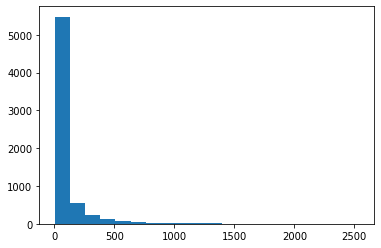

In [ ]:
plt.hist(predicted.values(),bins=20)

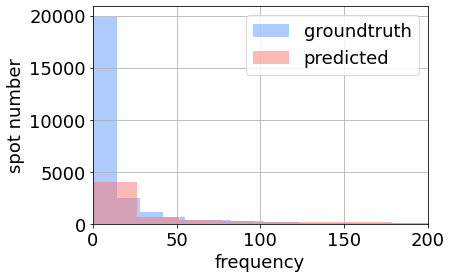

In [ ]:
import pandas as pd
# import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
pd.Series(np.array(list(groundtruth.values()))).hist(color="#5F9BFF", alpha=.5, bins=100, label='groundtruth')
pd.Series(np.array(list(predicted.values()))).hist(color="#F8766D", alpha=.5, bins=100, label='predicted')

plt.xlabel("frequency")
plt.ylabel("spot number")
plt.xlim(0, 200)
plt.legend()
plt.show()

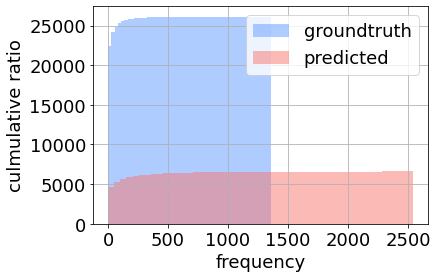

In [ ]:
import pandas as pd
# import matplotlib.pyplot as plt
gt = np.array(list(groundtruth.values()))
pred = np.array(list(predicted.values()))
#gt = gt/sum(gt)
#pred = pred/sum(pred)
pd.Series(gt).hist(color="#5F9BFF", bins=50, alpha=.5,label='groundtruth', cumulative=True)
pd.Series(pred).hist(color="#F8766D", bins=50,alpha=.5, label='predicted',cumulative=True)
plt.xlabel("frequency")
plt.ylabel("culmulative ratio")
plt.legend()
plt.show()

Spot-Spot間のSimilarity

In [ ]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(item_emb.detach().numpy(), item_emb.detach().numpy())

In [ ]:
cos_sim.shape

(42852, 42852)

In [ ]:
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
spot_names = df['spot_name'].values
cities = df['city'].values

In [ ]:
def visualize_neighbor(spot_index):
    K = 20
    index = spot_index
    # ソートはされていない上位k件のインデックス
    unsorted_max_indices = np.argpartition(-cos_sim[index], K)[:K]

    # 上位k件の値
    y = cos_sim[index][unsorted_max_indices]

    # 大きい順にソートし、インデックスを取得
    indices = np.argsort(-y)

    # 類似度上位k件のインデックス
    max_k_indices = unsorted_max_indices[indices]
    map = folium.Map(location=[df.loc[index, 'latitude'],df.loc[index, 'longitude']], zoom_start=5)
    for indice in max_k_indices[1:]:
        spot_name = df.loc[indice, 'spot_name']
        lat = df.loc[indice, 'latitude']
        lon = df.loc[indice, 'longitude']
        score = y[indices[i]]
        folium.Marker(
            location=[lat,lon],
            popup=df.loc[indice, 'spot_name'],
            icon=folium.Icon(color='blue')
        ).add_to(map)

    folium.Marker(
        location=[df.loc[index, 'latitude'],df.loc[index, 'longitude']],
        popup=df.loc[index, 'spot_name'],
        icon=folium.Icon(color='red')
    ).add_to(map)
    return map

In [ ]:
cos_sim
K = 20
index = 1
# ソートはされていない上位k件のインデックス
unsorted_max_indices = np.argpartition(-cos_sim[index], K)[:K]

# 上位k件の値
y = cos_sim[index][unsorted_max_indices]

# 大きい順にソートし、インデックスを取得
indices = np.argsort(-y)

# 類似度上位k件のインデックス
max_k_indices = unsorted_max_indices[indices]
source_spot = spot_names[index]
print(f'source: {spot_names[index]}')
for i in range(K):
    print(i)
    print(spot_names[max_k_indices[i]],cities[max_k_indices[i]] ,y[indices][i])

source: 旭山動物園
0
旭山動物園 旭川市 1.0000004
1
ファーム富田 中富良野町（空知郡） 0.78073305
2
層雲峡（北海道上川町） 上川町（上川郡） 0.77000934
3
小樽運河 小樽市 0.76075286
4
青い池 美瑛町（上川郡） 0.74950844
5
白い恋人パーク 札幌市西区 0.7469791
6
大通公園 札幌市中央区 0.71833926
7
札幌市時計台 札幌市中央区 0.7129311
8
ラベンダー 上富良野町（空知郡） 0.68667376
9
さっぽろテレビ塔 札幌市中央区 0.6818371
10
ノースサファリサッポロ 札幌市南区 0.6814841
11
ラベンダー畑 上富良野町（空知郡） 0.67339677
12
札幌ステラプレイス 札幌市中央区 0.6727606
13
千歳アウトレットモール・レラ 千歳市 0.6726579
14
円山動物園 札幌市中央区 0.67249167
15
札幌ドーム 札幌市豊平区 0.6706937
16
層雲峡温泉 上川町（上川郡） 0.66983813
17
四季彩の丘 美瑛町（上川郡） 0.6628675
18
旭岳ロープウエイ 東川町（上川郡） 0.6491598
19
藻岩山（北海道札幌市） 札幌市南区 0.6422584


userのreviewのtfidf

In [ ]:
df_train = pd.read_csv('/home/yamanishi/project/trip_recommend/model/recommendation/data/df_review_train.csv')

In [ ]:
df_train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'spot', 'pref', 'title', 'review',
       'rating', 'tag', 'sex', 'age', 'name', 'url', 'visit_time'],
      dtype='object')

In [ ]:
dist = [2,5,10,20]
recall = []